In [1]:
from arcgis import GIS
gis = GIS('pro')

In [12]:
#Search for a dataset of HUCs 
search_results = gis.content.search('Watershed Boundaries owner:Federal_User_Community',
                                    outside_org=True)
search_results

[<Item title:"Watershed Boundaries" type:Map Image Layer owner:Federal_User_Community>,
 <Item title:"Great Smoky Mountains Watersheds" type:Web Map owner:Federal_User_Community>,
 <Item title:"Hydrography Viewer" type:Web Mapping Application owner:Federal_User_Community>,
 <Item title:"Great Smoky Mountains Downstream Flow Path" type:Web Map owner:Federal_User_Community>,
 <Item title:"Great Smoky Mountains Watersheds" type:Feature Layer Collection owner:Federal_User_Community>]

<Item title:"Watershed Boundaries" type:Map Image Layer owner:Federal_User_Community>
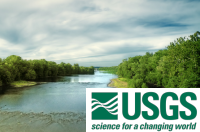

In [13]:
item = search_results[0]
item

In [19]:
layers = item.layers
for layer in layers:
    print (layer.properties.name, layer.properties.type)

WBDLine Feature Layer
2-digit HU (Region) Feature Layer
4-digit HU (Subregion) Feature Layer
6-digit HU (Basin) Feature Layer
8-digit HU  (Subbasin) Feature Layer
10-digit HU (Watershed) Feature Layer
12-digit HU (Subwatershed) Feature Layer
14-digit HU Feature Layer


Layers: https://developers.arcgis.com/python/guide/working-with-feature-layers-and-features/

In [34]:
huc8 = layers[4]
for fld in huc8.properties.fields:
    print (fld.name)

OBJECTID
SHAPE
TNMID
METASOURCEID
SOURCEDATADESC
SOURCEORIGINATOR
SOURCEFEATUREID
LOADDATE
GNIS_ID
AREAACRES
AREASQKM
STATES
HUC8
NAME
SHAPE_Length
SHAPE_Area


In [37]:
from arcgis.features import FeatureLayer

In [38]:
huc8.properties.capabilities

'Map,Query,Data'